以下是整個流程的簡要總結，幫助初學者理解如何將這些段落串接起來：

1. 數據準備與特徵工程：
從數據清理、特徵生成到標準化，這部分負責輸入數據的處理，確保後續的模型能正確接收和解讀。

2. 模型訓練與預測：
使用回歸和分類模型分別預測價格和漲跌方向，並生成測試集的預測結果，這些數據是後續評估的基礎。

3. 模型評估：
通過指標（如 MSE 和混淆矩陣）量化模型的性能，幫助判斷模型是否有效。

4. 結果視覺化：
用圖形化的方式展示預測效果，直觀地呈現模型與實際情況的差異。

In [1]:
# 匯入必要的 Python 套件
# pandas: 用於處理結構化的表格數據
# numpy: 用於進行高效的數值運算
# sklearn: 提供機器學習模型與數據處理工具
# matplotlib: 用於繪製數據圖表
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
import matplotlib.pyplot as plt

# 設置中文字體
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
plt.rcParams['axes.unicode_minus'] = False


# 本段程式的目的是匯入所有需要的套件，這些工具將用於數據處理、模型訓練和可視化。
# 匯入順序上，先匯入標準庫，再匯入第三方庫。

In [2]:
# 定義讀取股票數據的函數
def prepare_stock_data_from_csv(file_path):
    """
    功能：
    1. 從 CSV 文件中讀取股票數據。
    2. 去掉列名稱的多餘空格，確保後續分析時能正確識別欄位。
    3. 處理日期列，將其轉換為日期格式，並設置為數據索引。
    
    輸入：
    - file_path: CSV 文件的路徑。
    
    輸出：
    - df: 處理後的股票數據。
    """
    try:
        # 嘗試以 UTF-8 編碼讀取文件
        df = pd.read_csv(file_path, encoding='utf-8')
    except UnicodeDecodeError:
        # 如果失敗則改用 Big5 編碼（台灣地區常見格式）
        df = pd.read_csv(file_path, encoding='big5')

    # 去除列名稱中的多餘空格，避免後續操作出現問題
    df.columns = df.columns.str.strip()

    # 如果數據中包含日期列，進行處理
    date_column = 'date'  # 假設日期欄位名稱為 'date'
    if date_column in df.columns:
        # 將日期欄位轉為 datetime 格式
        df[date_column] = pd.to_datetime(df[date_column])
        # 設置日期為數據索引
        df.set_index(date_column, inplace=True)

    return df

# 使用函數讀取股票數據
csv_file_path = "6510_data.csv"  # 替換為實際的文件路徑
df = prepare_stock_data_from_csv(csv_file_path)

# 查看數據的前幾行，檢查是否正確讀取
print("數據預覽：")
print(df.head())

# 本段功能：讀取股票數據，處理欄位名稱和日期列，確保數據格式正確。

數據預覽：
              開盤價    最高價    最低價    收盤價       成交股數       成交金額           市值  \
date                                                                        
2016-01-04  590.0  622.0  580.0  615.0  1471264.0  878440040  17221230000   
2016-01-05  590.0  622.0  580.0  615.0  1471264.0  878440040  17221230000   
2016-01-06  590.0  622.0  580.0  615.0  1471264.0  878440040  17221230000   
2016-01-07  590.0  622.0  580.0  615.0  1471264.0  878440040  17221230000   
2016-01-08  590.0  622.0  580.0  615.0  1471264.0  878440040  17221230000   

                大盤指數   SMA5   SMA20  ...  去年累計營收   SMA5斜率   SMA20斜率   SMA60斜率  \
date                                 ...                                        
2016-01-04  12844.34  632.8  674.85  ...  969245  0.09292  0.003853  0.292769   
2016-01-05  12782.35  632.8  674.85  ...  969245  0.09292  0.003853  0.292769   
2016-01-06  12648.25  632.8  674.85  ...  969245  0.09292  0.003853  0.292769   
2016-01-07  12429.29  632.8  674.85  ...  969245 

In [3]:
# 定義數據清理的函數
def clean_data(df):
    """
    功能：
    1. 替換數據中的無窮大值和無窮小值為 NaN。
    2. 移除數值列中的極端值（超過平均值 ± 3 個標準差的值）。
    3. 使用前後值填充缺失數據，避免空值影響模型訓練。
    
    輸入：
    - df: 原始數據框。
    
    輸出：
    - df: 清理後的數據框。
    """
    # 替換無窮大的數值（例如除以零產生的數據）為 NaN
    df = df.replace([np.inf, -np.inf], np.nan)

    # 找出所有數值型欄位
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    for col in numeric_columns:
        # 計算平均值和標準差
        mean = df[col].mean()
        std = df[col].std()
        # 剪裁極端值為 (平均值 ± 3*標準差) 的範圍內
        df[col] = df[col].clip(mean - 3*std, mean + 3*std)

    # 填充數據中的缺失值，先用前一個值填充，然後用後一個值填充
    df = df.ffill().bfill()

    return df

# 對數據進行清理
df_cleaned = clean_data(df)

# 查看清理後的數據，檢查清理是否成功
print("清理後的數據預覽：")
print(df_cleaned.head())

# 本段功能：清理數據，處理極端值和缺失值，保證數據的整潔性和一致性。

清理後的數據預覽：
              開盤價    最高價    最低價    收盤價       成交股數         成交金額           市值  \
date                                                                          
2016-01-04  590.0  622.0  580.0  615.0  1471264.0  878440040.0  17221230000   
2016-01-05  590.0  622.0  580.0  615.0  1471264.0  878440040.0  17221230000   
2016-01-06  590.0  622.0  580.0  615.0  1471264.0  878440040.0  17221230000   
2016-01-07  590.0  622.0  580.0  615.0  1471264.0  878440040.0  17221230000   
2016-01-08  590.0  622.0  580.0  615.0  1471264.0  878440040.0  17221230000   

                大盤指數   SMA5   SMA20  ...  去年累計營收   SMA5斜率   SMA20斜率   SMA60斜率  \
date                                 ...                                        
2016-01-04  12844.34  632.8  674.85  ...  969245  0.09292  0.003853  0.292769   
2016-01-05  12782.35  632.8  674.85  ...  969245  0.09292  0.003853  0.292769   
2016-01-06  12648.25  632.8  674.85  ...  969245  0.09292  0.003853  0.292769   
2016-01-07  12429.29  632.8  67

In [4]:
# 定義創建目標變數的函數
def create_target_variables(df, close_price_column, target_days=5):
    """
    功能：
    1. 創建 'price_target' 欄位，表示未來指定天數後的收盤價。
    2. 創建 'direction_target' 欄位，表示漲跌情況（1 表示上漲，0 表示下跌）。
    
    輸入：
    - df: 股票數據框。
    - close_price_column: 用於計算目標變數的收盤價欄位名稱。
    - target_days: 預測的天數間隔（默認為 5 天）。
    
    輸出：
    - df: 加入目標變數的數據框。
    """
    # 創建未來價格目標
    df['price_target'] = df[close_price_column].shift(-target_days)

    # 創建漲跌目標（比較未來價格和當前價格）
    df['direction_target'] = (df['price_target'] > df[close_price_column]).astype(int)

    return df

# 創建目標變數
df_with_targets = create_target_variables(df_cleaned, '收盤價')

# 查看加入目標變數後的數據
print("加入目標變數後的數據預覽：")
print(df_with_targets.head())

# 本段功能：生成未來價格和漲跌標籤，提供監督學習模型的訓練標籤。


加入目標變數後的數據預覽：
              開盤價    最高價    最低價    收盤價       成交股數         成交金額           市值  \
date                                                                          
2016-01-04  590.0  622.0  580.0  615.0  1471264.0  878440040.0  17221230000   
2016-01-05  590.0  622.0  580.0  615.0  1471264.0  878440040.0  17221230000   
2016-01-06  590.0  622.0  580.0  615.0  1471264.0  878440040.0  17221230000   
2016-01-07  590.0  622.0  580.0  615.0  1471264.0  878440040.0  17221230000   
2016-01-08  590.0  622.0  580.0  615.0  1471264.0  878440040.0  17221230000   

                大盤指數   SMA5   SMA20  ...   SMA20斜率   SMA60斜率  投信買賣超  投信買賣超佔比  \
date                                 ...                                       
2016-01-04  12844.34  632.8  674.85  ...  0.003853  0.292769    0.0      0.0   
2016-01-05  12782.35  632.8  674.85  ...  0.003853  0.292769    0.0      0.0   
2016-01-06  12648.25  632.8  674.85  ...  0.003853  0.292769    0.0      0.0   
2016-01-07  12429.29  632.8  674

In [5]:
# 定義準備訓練數據的函數
def prepare_training_data(df, close_price_column, target_days=5):
    """
    功能：
    1. 使用之前的函數創建目標變數（價格和漲跌）。
    2. 選擇模型需要的特徵，並檢查是否存在於數據框中。
    3. 清理掉包含缺失值的行。
    4. 對特徵進行標準化，將其縮放到統一範圍內。
    
    輸入：
    - df: 股票數據框。
    - close_price_column: 收盤價的欄位名稱。
    - target_days: 預測的天數間隔（默認為 5 天）。
    
    輸出：
    - X: 特徵數據框（已標準化）。
    - y_price: 價格目標值。
    - y_direction: 漲跌目標值。
    - scaler: 用於標準化的物件（可用於未來數據）。
    """
    # 創建目標變數
    df = create_target_variables(df, close_price_column, target_days)

    # 定義模型需要的特徵
    features = [
        '收盤價', 'SMA5', 'SMA20', 'SMA60',
        '乖離率_SMA250', '乖離率_SMA60', '乖離率_SMA5',
        '價格動量5', '價格動量20', '價格動量60',
        '價格波動率', '交易活絡度', 'MA反轉',
        '融資使用率', '營收月增率',
        'SMA5斜率', 'SMA20斜率', 'SMA60斜率',
        '投信買賣超', '投信買賣超佔比', '投信影響力'
    ]

    # 確認數據框中存在的特徵
    available_features = [f for f in features if f in df.columns]

    # 去掉包含缺失值的行
    df = df.dropna(subset=available_features + ['price_target', 'direction_target'])

    # 使用 StandardScaler 對特徵進行標準化
    scaler = StandardScaler()
    X = pd.DataFrame(
        scaler.fit_transform(df[available_features]),
        columns=available_features,
        index=df.index
    )

    # 定義目標變數
    y_price = df['price_target']  # 價格目標
    y_direction = df['direction_target']  # 漲跌目標

    return X, y_price, y_direction, scaler

# 使用函數準備訓練數據
X, y_price, y_direction, scaler = prepare_training_data(df_with_targets, '收盤價')

# 查看特徵數據的前幾行
print("特徵數據預覽：")
print(X.head())

# 查看目標變數的基本資訊
print("價格目標數據統計：")
print(y_price.describe())
print("漲跌目標數據分佈：")
print(y_direction.value_counts())

# 本段功能：準備訓練數據，包含特徵選擇、標準化及目標變數生成。

特徵數據預覽：
                 收盤價      SMA5    SMA20     SMA60  乖離率_SMA250  乖離率_SMA60  \
date                                                                       
2016-01-04 -0.395368 -0.331131 -0.18257 -0.146243    1.258794   0.131995   
2016-01-05 -0.395368 -0.331131 -0.18257 -0.146243    1.258794   0.131995   
2016-01-06 -0.395368 -0.331131 -0.18257 -0.146243    1.258794   0.131995   
2016-01-07 -0.395368 -0.331131 -0.18257 -0.146243    1.258794   0.131995   
2016-01-08 -0.395368 -0.331131 -0.18257 -0.146243    1.258794   0.131995   

            乖離率_SMA5     價格動量5    價格動量20    價格動量60  ...     交易活絡度      MA反轉  \
date                                                ...                       
2016-01-04  0.649127  0.649127  0.122257  0.131995  ...  2.851101  0.030148   
2016-01-05  0.649127  0.649127  0.122257  0.131995  ...  2.851101  0.030148   
2016-01-06  0.649127  0.649127  0.122257  0.131995  ...  2.851101  0.030148   
2016-01-07  0.649127  0.649127  0.122257  0.131995  ...  2.85110

In [6]:
# 定義訓練模型的函數
def train_models(X, y_price, y_direction):
    """
    訓練價格預測（線性回歸）和漲跌預測（邏輯回歸）模型
    - 將特徵值和目標值分割為訓練集與測試集
    - 訓練兩種不同類型的模型（回歸和分類）
    - 返回模型、測試數據以及預測結果

    參數：
    X: 標準化後的特徵值（DataFrame）
    y_price: 價格預測的目標值（Series）
    y_direction: 漲跌預測的目標值（Series）

    輸出：
    - 訓練後的價格預測模型 (LinearRegression)
    - 訓練後的漲跌預測模型 (LogisticRegression)
    - 測試特徵值 (X_test)
    - 測試集的價格目標值 (y_price_test)
    - 測試集的漲跌目標值 (y_dir_test)
    - 價格預測結果 (price_pred)
    - 漲跌預測結果 (direction_pred)
    """
    # 分割訓練集和測試集
    # - shuffle=False 確保時間序列數據保持順序，模擬真實場景中的預測
    X_train, X_test, y_price_train, y_price_test, y_dir_train, y_dir_test = train_test_split(
        X, y_price, y_direction, test_size=0.2, shuffle=False
    )

    # 訓練價格預測模型（線性回歸模型）
    price_model = LinearRegression()
    price_model.fit(X_train, y_price_train)  # 利用訓練數據擬合模型
    price_pred = price_model.predict(X_test)  # 利用測試數據進行預測

    # 訓練漲跌預測模型（邏輯回歸模型）
    direction_model = LogisticRegression(random_state=42, max_iter=1000)
    direction_model.fit(X_train, y_dir_train)  # 擬合邏輯回歸模型
    direction_pred = direction_model.predict(X_test)  # 預測測試集的漲跌方向

    # 返回訓練好的模型、測試集及預測結果
    return (price_model, direction_model, X_test, y_price_test, y_dir_test, price_pred, direction_pred)


# 訓練模型
results = train_models(X, y_price, y_direction)
price_model, direction_model, X_test, y_price_test, y_dir_test, price_pred, direction_pred = results

# 查看價格模型的係數
print("價格模型係數：")
print(price_model.coef_)

# 查看邏輯回歸模型的權重
print("邏輯回歸模型權重：")
print(direction_model.coef_)

# 本段功能：訓練兩個模型，分別用於預測價格和漲跌方向。


# 1. 價格模型的係數解釋
# 價格模型的係數來自於線性回歸模型 (LinearRegression)，它表示每個特徵對目標變數（價格）的影響方向和大小。

# a. 係數的解讀
# 每個數值與對應的特徵相匹配，表示該特徵變動一個單位時，預測價格的變化量（在其他條件保持不變的情況下）。
# 正/負係數：特徵值增加會導致價格增加/下降。
# 如果第一個特徵的值增加1，則價格會增加 239.09 單位。
# 如果第二個特徵的值增加1，價格會下降 54.63 單位。

# b. 特徵影響的排序
# 根據係數的絕對值，我們可以排序出哪些特徵對價格的影響最顯著。例如：
# 239.09 表示第一個特徵的影響力最大。
# -54.63 表示第二個特徵的影響也很顯著，但方向相反。
# 這些資訊可用於選擇影響價格的重要特徵，進一步優化模型。

# 2. 邏輯回歸模型的權重解釋
# 邏輯回歸模型 (LogisticRegression) 的權重表示每個特徵對輸出（漲跌方向）的影響程度。

# a. 權重的解讀
#   1. 權重的符號：
#   正/負值：特徵值增加會增加/減少預測為「上漲」的概率。
#   2. 權重的大小：
#   權重的絕對值越大，該特徵對漲跌方向的影響力越大。
#   第二個特徵的權重為 -0.7607，表示該特徵值增加會降低預測「上漲」的概率。
#   第三個特徵的權重為 0.4237，表示該特徵值增加會提高預測「上漲」的概率。

# b. 特徵影響的排序
#   同樣，可以根據權重絕對值排序，找出對預測漲跌方向影響最大的特徵。


價格模型係數：
[239.08813401 -54.62977958  41.13885797  33.48834499   9.77429789
   7.96729588  -6.15587628  -6.15587628  21.18692503   7.96729588
  -0.58548006  -1.51103716 -10.53481543   0.61634114  -2.75107266
  -3.17555478  -3.28186839  -3.19116267   2.10675375  35.90090975
 -31.34417217]
邏輯回歸模型權重：
[[-0.20311763 -0.76074678  0.42367045  0.34379651  0.23735839  0.30892276
  -0.11136171 -0.11136171 -0.01128186  0.30892276  0.07962023 -0.18774872
   0.09521599  0.12858169 -0.10423318 -0.24899535 -0.44821693 -0.08441811
   0.11781664  0.3716488  -0.22724043]]


In [7]:
# 定義評估模型的函數
def evaluate_models(y_price_test, price_pred, y_dir_test, direction_pred):
    """
    評估價格預測模型與漲跌預測模型的性能。
    - 計算價格預測的誤差和解釋力（MSE 和 R²）
    - 計算漲跌預測的準確率和分類報告

    參數：
    y_price_test: 測試集的價格目標值（真實值）
    price_pred: 價格預測模型的預測結果
    y_dir_test: 測試集的漲跌目標值（真實值）
    direction_pred: 漲跌預測模型的預測結果

    輸出：
    - 評估指標會直接列印於終端，包括 MSE, R², 準確率 和 分類報告
    """

    # 計算價格預測性能
    mse = mean_squared_error(y_price_test, price_pred)  # 平均平方誤差，數值越小越好
    r2 = r2_score(y_price_test, price_pred)  # R² 解釋力，越接近 1.0 越好

    # 計算漲跌預測性能
    accuracy = accuracy_score(y_dir_test, direction_pred)  # 準確率

    # 列印價格預測性能
    print("\n價格預測模型性能：")
    print(f'均方誤差 (MSE): {mse:.2f}')
    print(f'R平方值 (R²): {r2:.2f}')

    # 列印漲跌預測性能
    print("\n漲跌預測模型性能：")
    print(f'準確率: {accuracy:.2f}')
    print("\n分類報告：")
    print(classification_report(y_dir_test, direction_pred))  # 更詳細的分類指標（如精確率、召回率）


# 評估模型
evaluate_models(y_price_test, price_pred, y_dir_test, direction_pred)

# 本段功能：評估模型性能，分析預測準確性。

# 1.價格預測模型：
# 均方誤差 (MSE)：衡量預測值和實際值的差異，越小越好，表示預測的準確度越高。
# R平方值 (R²)：解釋變異的百分比，越接近 1，表示模型對數據的解釋能力越強。

# 2. 漲跌預測模型：
# 準確率：正確分類的比例，幫助判斷模型對漲跌方向的預測是否準確。
# 分類報告：顯示更多細節，包括：
#   精確率 (Precision)：預測為某類時正確的比例。
#   召回率 (Recall)：實際屬於某類被正確識別的比例。
#   F1 分數：精確率和召回率的加權平均，提供平衡的評估。



價格預測模型性能：
均方誤差 (MSE): 843.89
R平方值 (R²): 0.72

漲跌預測模型性能：
準確率: 0.54

分類報告：
              precision    recall  f1-score   support

           0       0.53      0.43      0.48       228
           1       0.54      0.63      0.58       239

    accuracy                           0.54       467
   macro avg       0.53      0.53      0.53       467
weighted avg       0.53      0.54      0.53       467



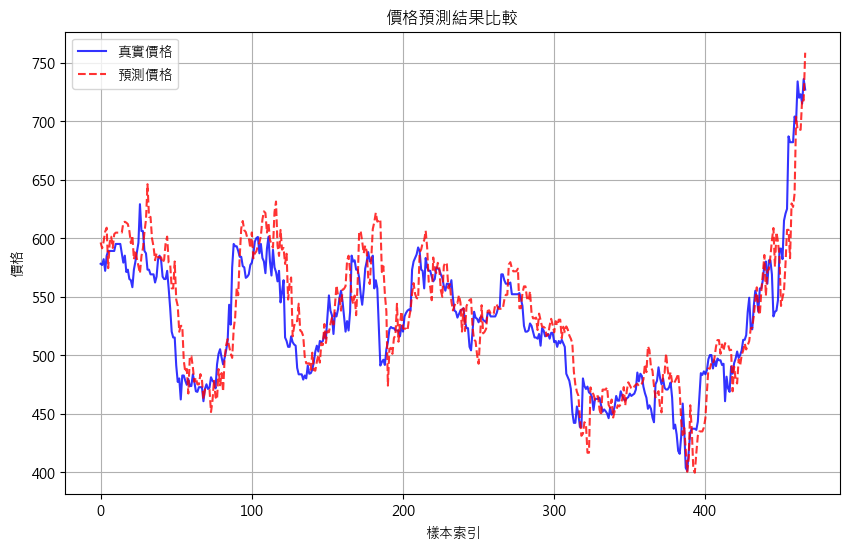

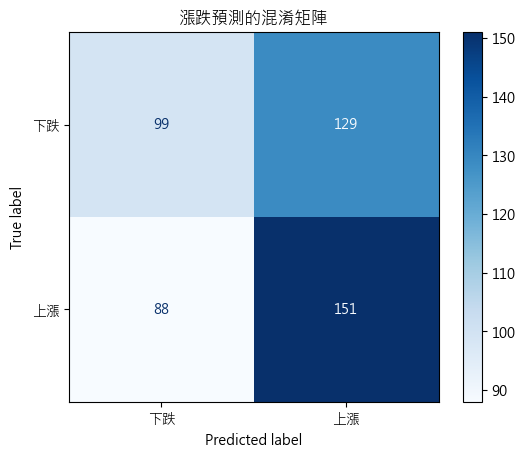

In [8]:
# 定義視覺化預測結果的函數
def visualize_predictions(y_price_test, price_pred, y_dir_test, direction_pred):
    """
    繪製價格預測結果與漲跌預測的混淆矩陣。
    - 價格預測：比較真實值與預測值，顯示兩者的趨勢對比
    - 漲跌預測：顯示混淆矩陣，評估分類準確性

    參數：
    y_price_test: 測試集的價格目標值（真實值）
    price_pred: 價格預測模型的預測結果
    y_dir_test: 測試集的漲跌目標值（真實值）
    direction_pred: 漲跌預測模型的預測結果

    輸出：
    - 生成兩個圖形：價格趨勢比較圖與漲跌混淆矩陣
    """
    # 引入繪圖庫
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

    # 繪製價格預測結果
    plt.figure(figsize=(10, 6))
    plt.plot(y_price_test.values, label='真實價格', color='blue', linestyle='-', alpha=0.8)
    plt.plot(price_pred, label='預測價格', color='red', linestyle='--', alpha=0.8)
    plt.title('價格預測結果比較')
    plt.xlabel('樣本索引')
    plt.ylabel('價格')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 繪製漲跌混淆矩陣
    cm = confusion_matrix(y_dir_test, direction_pred)  # 計算混淆矩陣
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["下跌", "上漲"])
    disp.plot(cmap='Blues')  # 使用藍色調的熱力圖
    plt.title('漲跌預測的混淆矩陣')
    plt.show()

# 假設之前的結果已經準備好，以下數據用於生成視覺化結果
# price_pred: 預測價格
# y_price_test: 實際測試價格
# direction_pred: 預測漲跌方向
# y_dir_test: 實際測試漲跌方向

visualize_predictions(y_price_test, price_pred, y_dir_test, direction_pred)

# 註解分析

# 1.價格預測圖：
# 真實價格 vs 預測價格：藍線代表真實值，橙線代表預測值，圖形直觀地展示模型的趨勢跟蹤能力。
# 幫助檢查預測是否接近真實值，並分析是否有偏差（如預測值落後或過於平滑）。

# 2. 漲跌混淆矩陣：
# 混淆矩陣的意義：行表示真實值，列表示預測值。
# 對角線元素表示正確預測數量，非對角線則為錯誤預測。
# 直觀指標：可幫助理解分類模型的錯誤類型（例如錯將上漲預測為下跌的次數）。

# 3.關鍵技術細節：
# 使用 ConfusionMatrixDisplay 自動生成格式化的矩陣圖，提升易讀性。
# 圖片格式和顏色設計友好，便於理解。
